In [1]:
import mne
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import numpy as np
from colour import Color
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from matplotlib.gridspec import GridSpec
import pyprep
from scipy import stats
from scipy.stats import zscore
import pandas as pd
from statannot import add_stat_annotation
import matplotlib.pyplot as plt
from mne_connectivity import spectral_connectivity_epochs

plt.rcParams["font.family"] = "Arial"
mne.__version__

'1.3.1'

In [2]:
n_part = 29 # number of participants

In [3]:
def get_stat(var): # get median and 25th, 75th percentiles
    print(f'{np.median(var):.2f} [{np.percentile(var, 25):.2f}-{np.percentile(var, 75):.2f}]')

In [5]:
fs = 500
electrodes = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T3', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T4', 'TP9', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP10', 'T5', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'T6', 'PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2']

dict_rows = {
    'Fp':0,
    'F':1,
    'FC':2,
    'T':-1,
    'TP':-1,
    'C':3,
    'CP':4,
    'P':5,
    'PO':6,
    'O':7,
}

dict_cols = {
    '9':-1,
    '7':0,
    '5':1,
    '3':2,
    '1':3,
    'z':4,
    '2':5,
    '4':6,
    '6':7,
    '8':8, 
    '10':-1
}

cols_seq = [dict_cols[re.split('(\d+)', i)[1]] if 'z' not in i else dict_cols[i[-1]] for i in electrodes]
rows_seq = [dict_rows[re.split('(\d+)', i)[0]] if 'z' not in i else dict_rows[i[:-1]] for i in electrodes]

cols_seq[electrodes.index('T3')] = 0
rows_seq[electrodes.index('T3')] = 3
cols_seq[electrodes.index('T4')] = 8
rows_seq[electrodes.index('T4')] = 3

cols_seq[electrodes.index('T5')] = 0
rows_seq[electrodes.index('T5')] = 5
cols_seq[electrodes.index('T6')] = 8
rows_seq[electrodes.index('T6')] = 5

nrows = max(rows_seq)+1
ncols = max(cols_seq)+1

figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(40, 25), sharex=True, sharey=True, dpi=200)

for e in range(len(electrodes)):
    if electrodes[e] in ['TP9', 'TP10']:
        continue
    axes[rows_seq[e]][cols_seq[e]].set_title(electrodes[e], fontsize=18, fontweight='bold')
    
pairs = [str(rows_seq[i])+str(cols_seq[i]) for i in range(len(electrodes))]
    
for row in range(nrows):
    for col in range(ncols):
        if str(row) + str(col) not in pairs:
            axes[row][col].set_axis_off()

# figure.subplots_adjust(right=0.8)
# cbar_ax = figure.add_axes([0.83, 0.4, 0.01, 0.3])
# cbar = figure.colorbar(cp, cax=cbar_ax)
# cbar.ax.set_title(mode, fontsize=18)
            
plt.suptitle('Smth', fontsize=32, y=0.95, fontweight='bold')
plt.show()

# Short stimuli wavelets

In [40]:
rest_erp_w = np.load('preprocesed_data/short_wavelets/power_rest.npy')
im_erp_w = np.load('preprocesed_data/short_wavelets/power_im.npy')

mu_ind_values = np.genfromtxt('preprocesed_data/long_wavelets/mu_freq.csv') # we use the same individual mu and beta frequencies
beta_ind_values = np.genfromtxt('preprocesed_data/long_wavelets/beta_freq.csv')

times = np.linspace(-0.5, 1, 75)
freqs = np.genfromtxt('preprocesed_data/short_wavelets/freqs.csv')

Text(0.5, 0.9, 'Sensorimotor (C3, CP3) wavelets and individual mu and beta frequencies (red)')

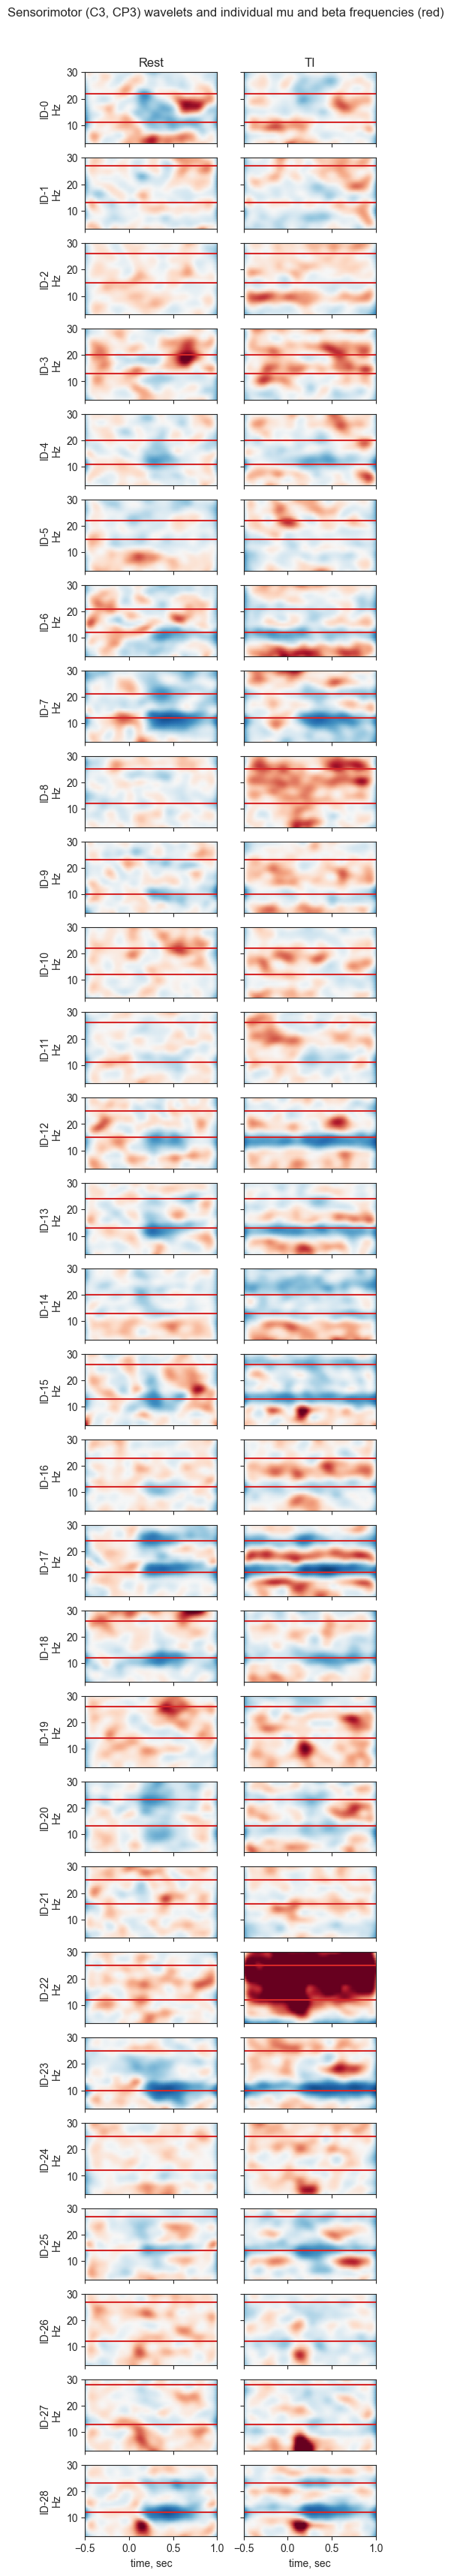

In [41]:
left_sm = [electrodes.index(i) for i in ['C3', 'CP3']]

fig, axes = plt.subplots(nrows=n_part, ncols=2, figsize=(5, n_part*1.5), dpi=100, sharex=True, sharey=True)

for i in range(n_part):
    axes[i][0].pcolormesh(times, freqs, np.mean(rest_erp_w[i, left_sm], axis=0)*100, vmin=-80, vmax=80, cmap='RdBu_r', shading='gouraud')    
    axes[i][1].pcolormesh(times, freqs, np.mean(im_erp_w[i, left_sm], axis=0)*100, vmin=-80, vmax=80, cmap='RdBu_r', shading='gouraud')
    
    for j in range(2):
        axes[i][j].axhline(mu_ind_values[i], color='tab:red')
        axes[i][j].axhline(beta_ind_values[i], color='tab:red')
    
    axes[i][0].set_ylabel('ID-'+str(i)+'\nHz')
    
axes[0][0].set_title('Rest')
axes[0][1].set_title('TI')

axes[-1][0].set_xlabel('time, sec')
axes[-1][1].set_xlabel('time, sec')

plt.suptitle('Sensorimotor (C3, CP3) wavelets and individual mu and beta frequencies (red)', y=0.9)

In [42]:
# cond = np.array(list(np.argwhere(mu_power_learning>0)[0]) + list(np.argwhere(mu_power_imagery>0)[:, 0])) # bad_imaginers
# cond = np.insert(cond, 0, 22) # very bad outlier
# not_cond = np.array([i for i in range(n_part) if i not in cond]) # good imaginers

# or
cond = np.array([22])
not_cond = np.array([i for i in range(n_part) if i not in cond]) # remove only bad outlier

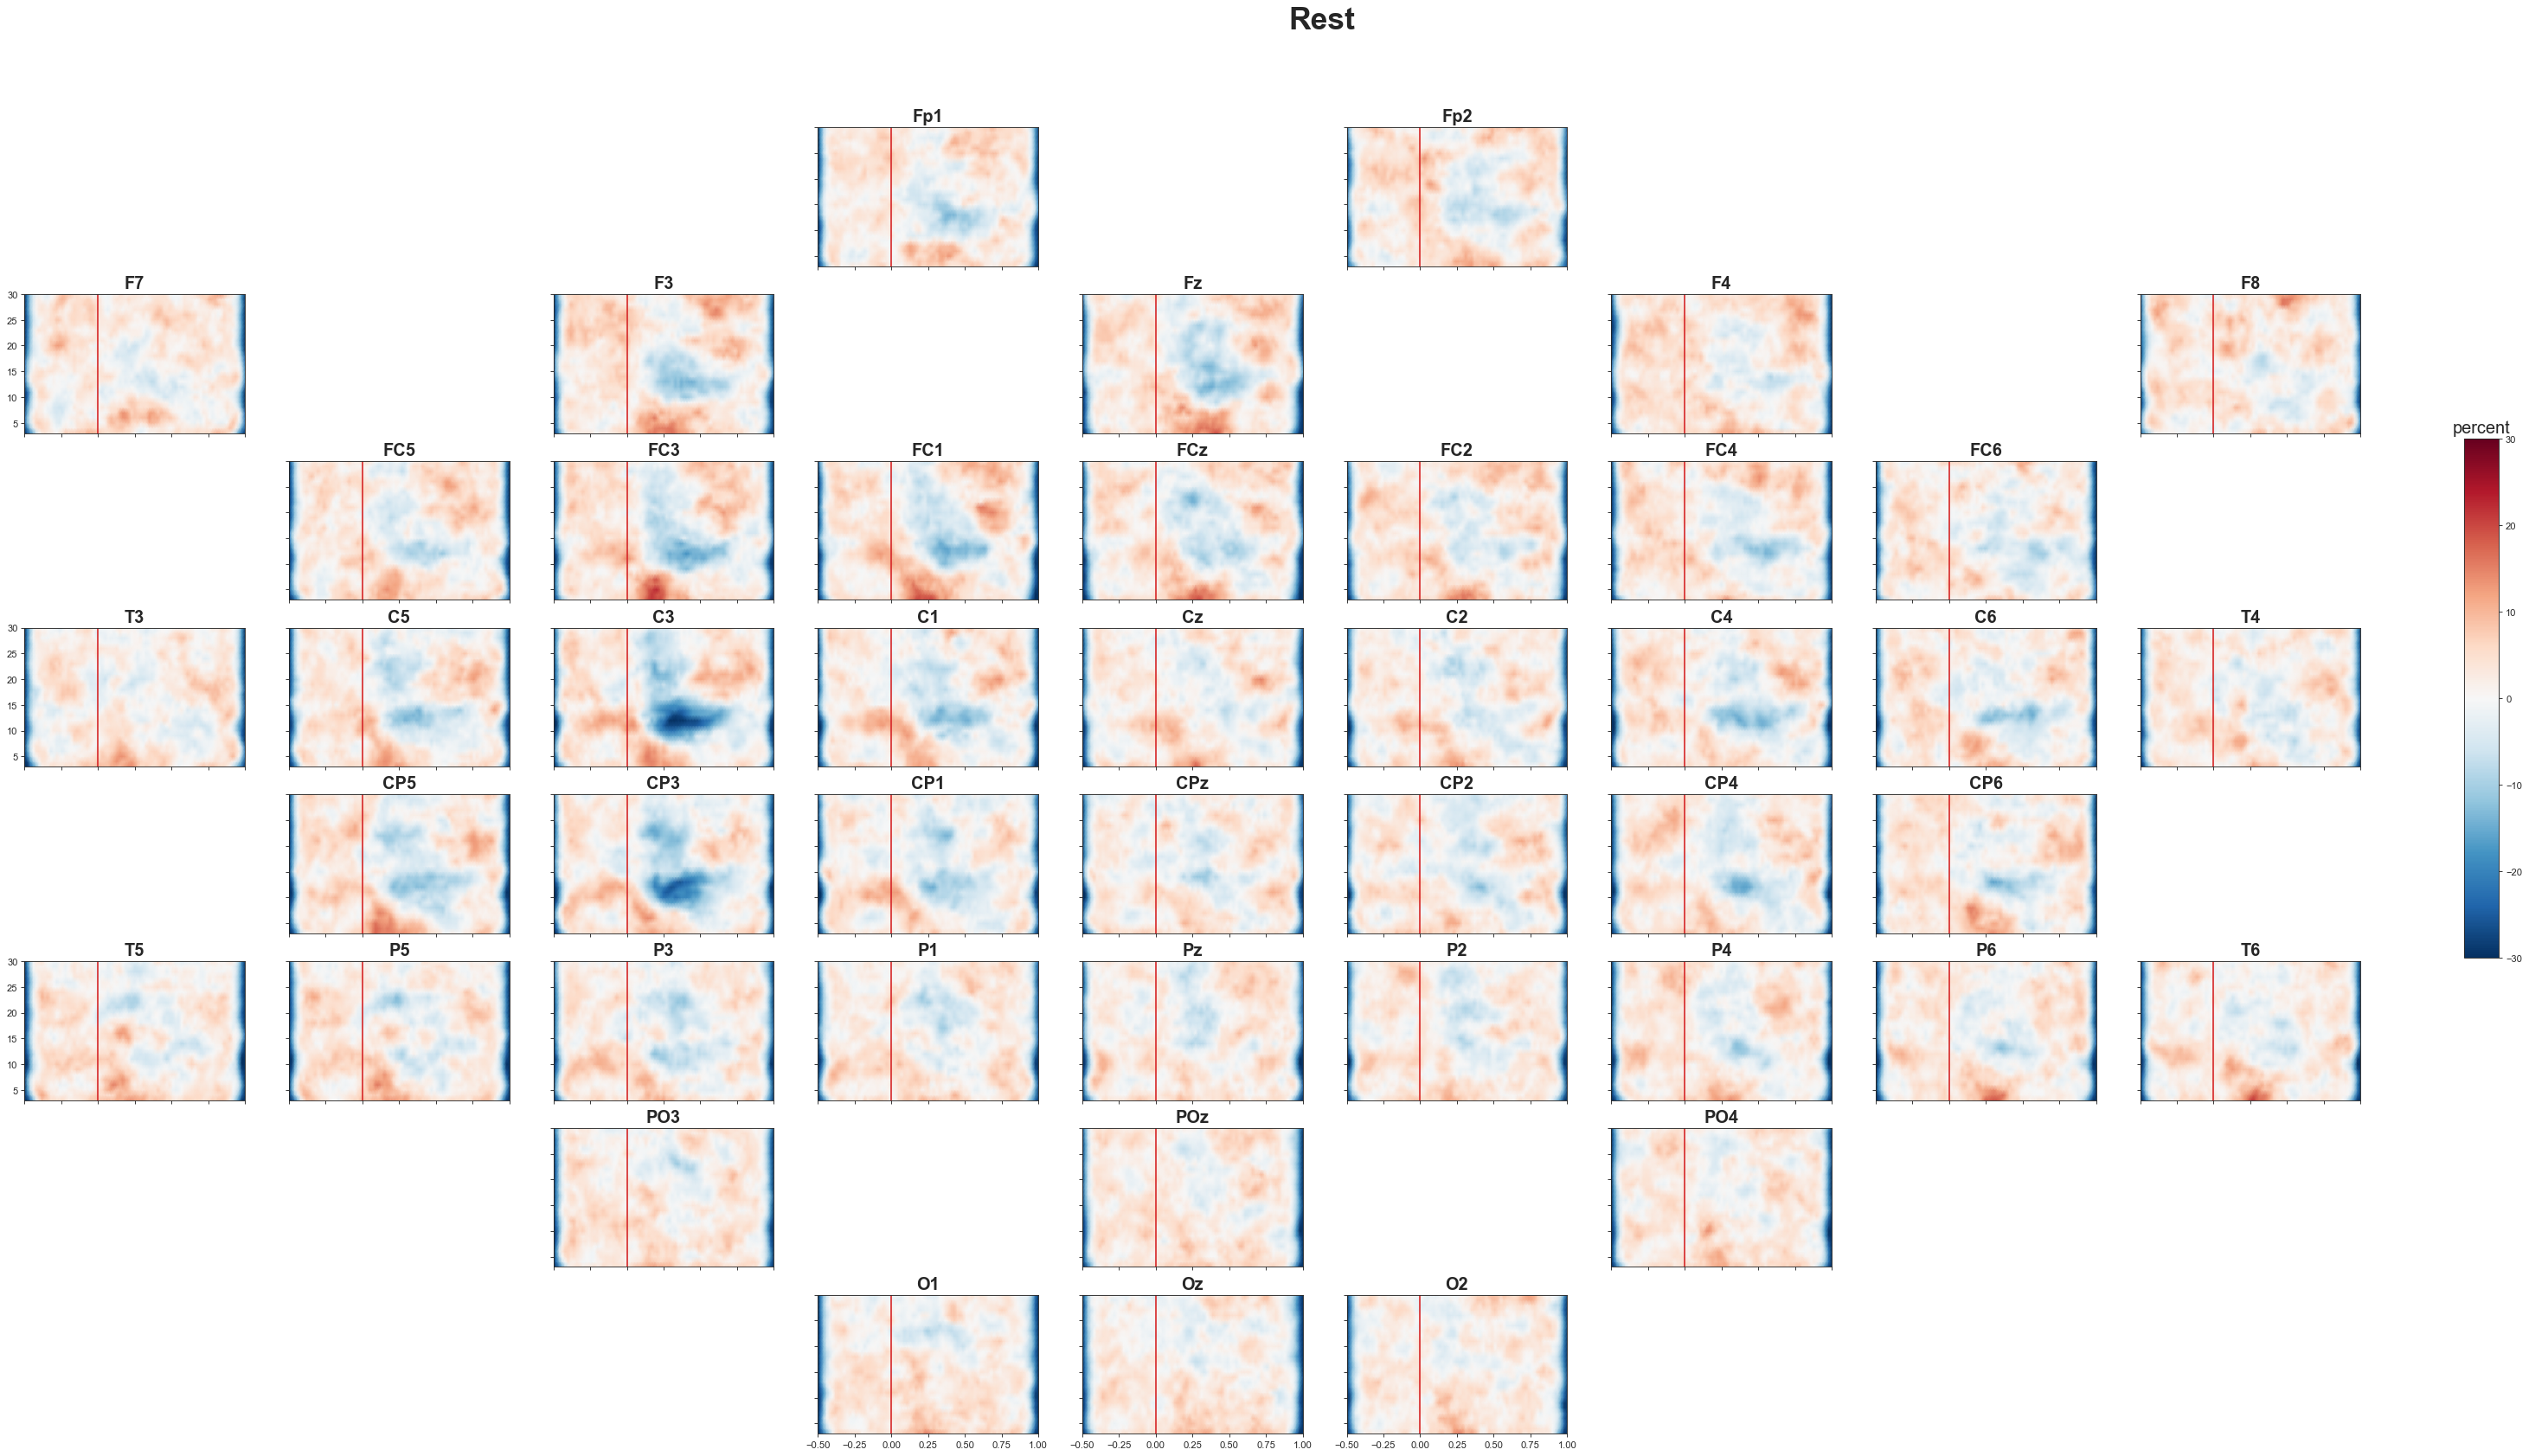

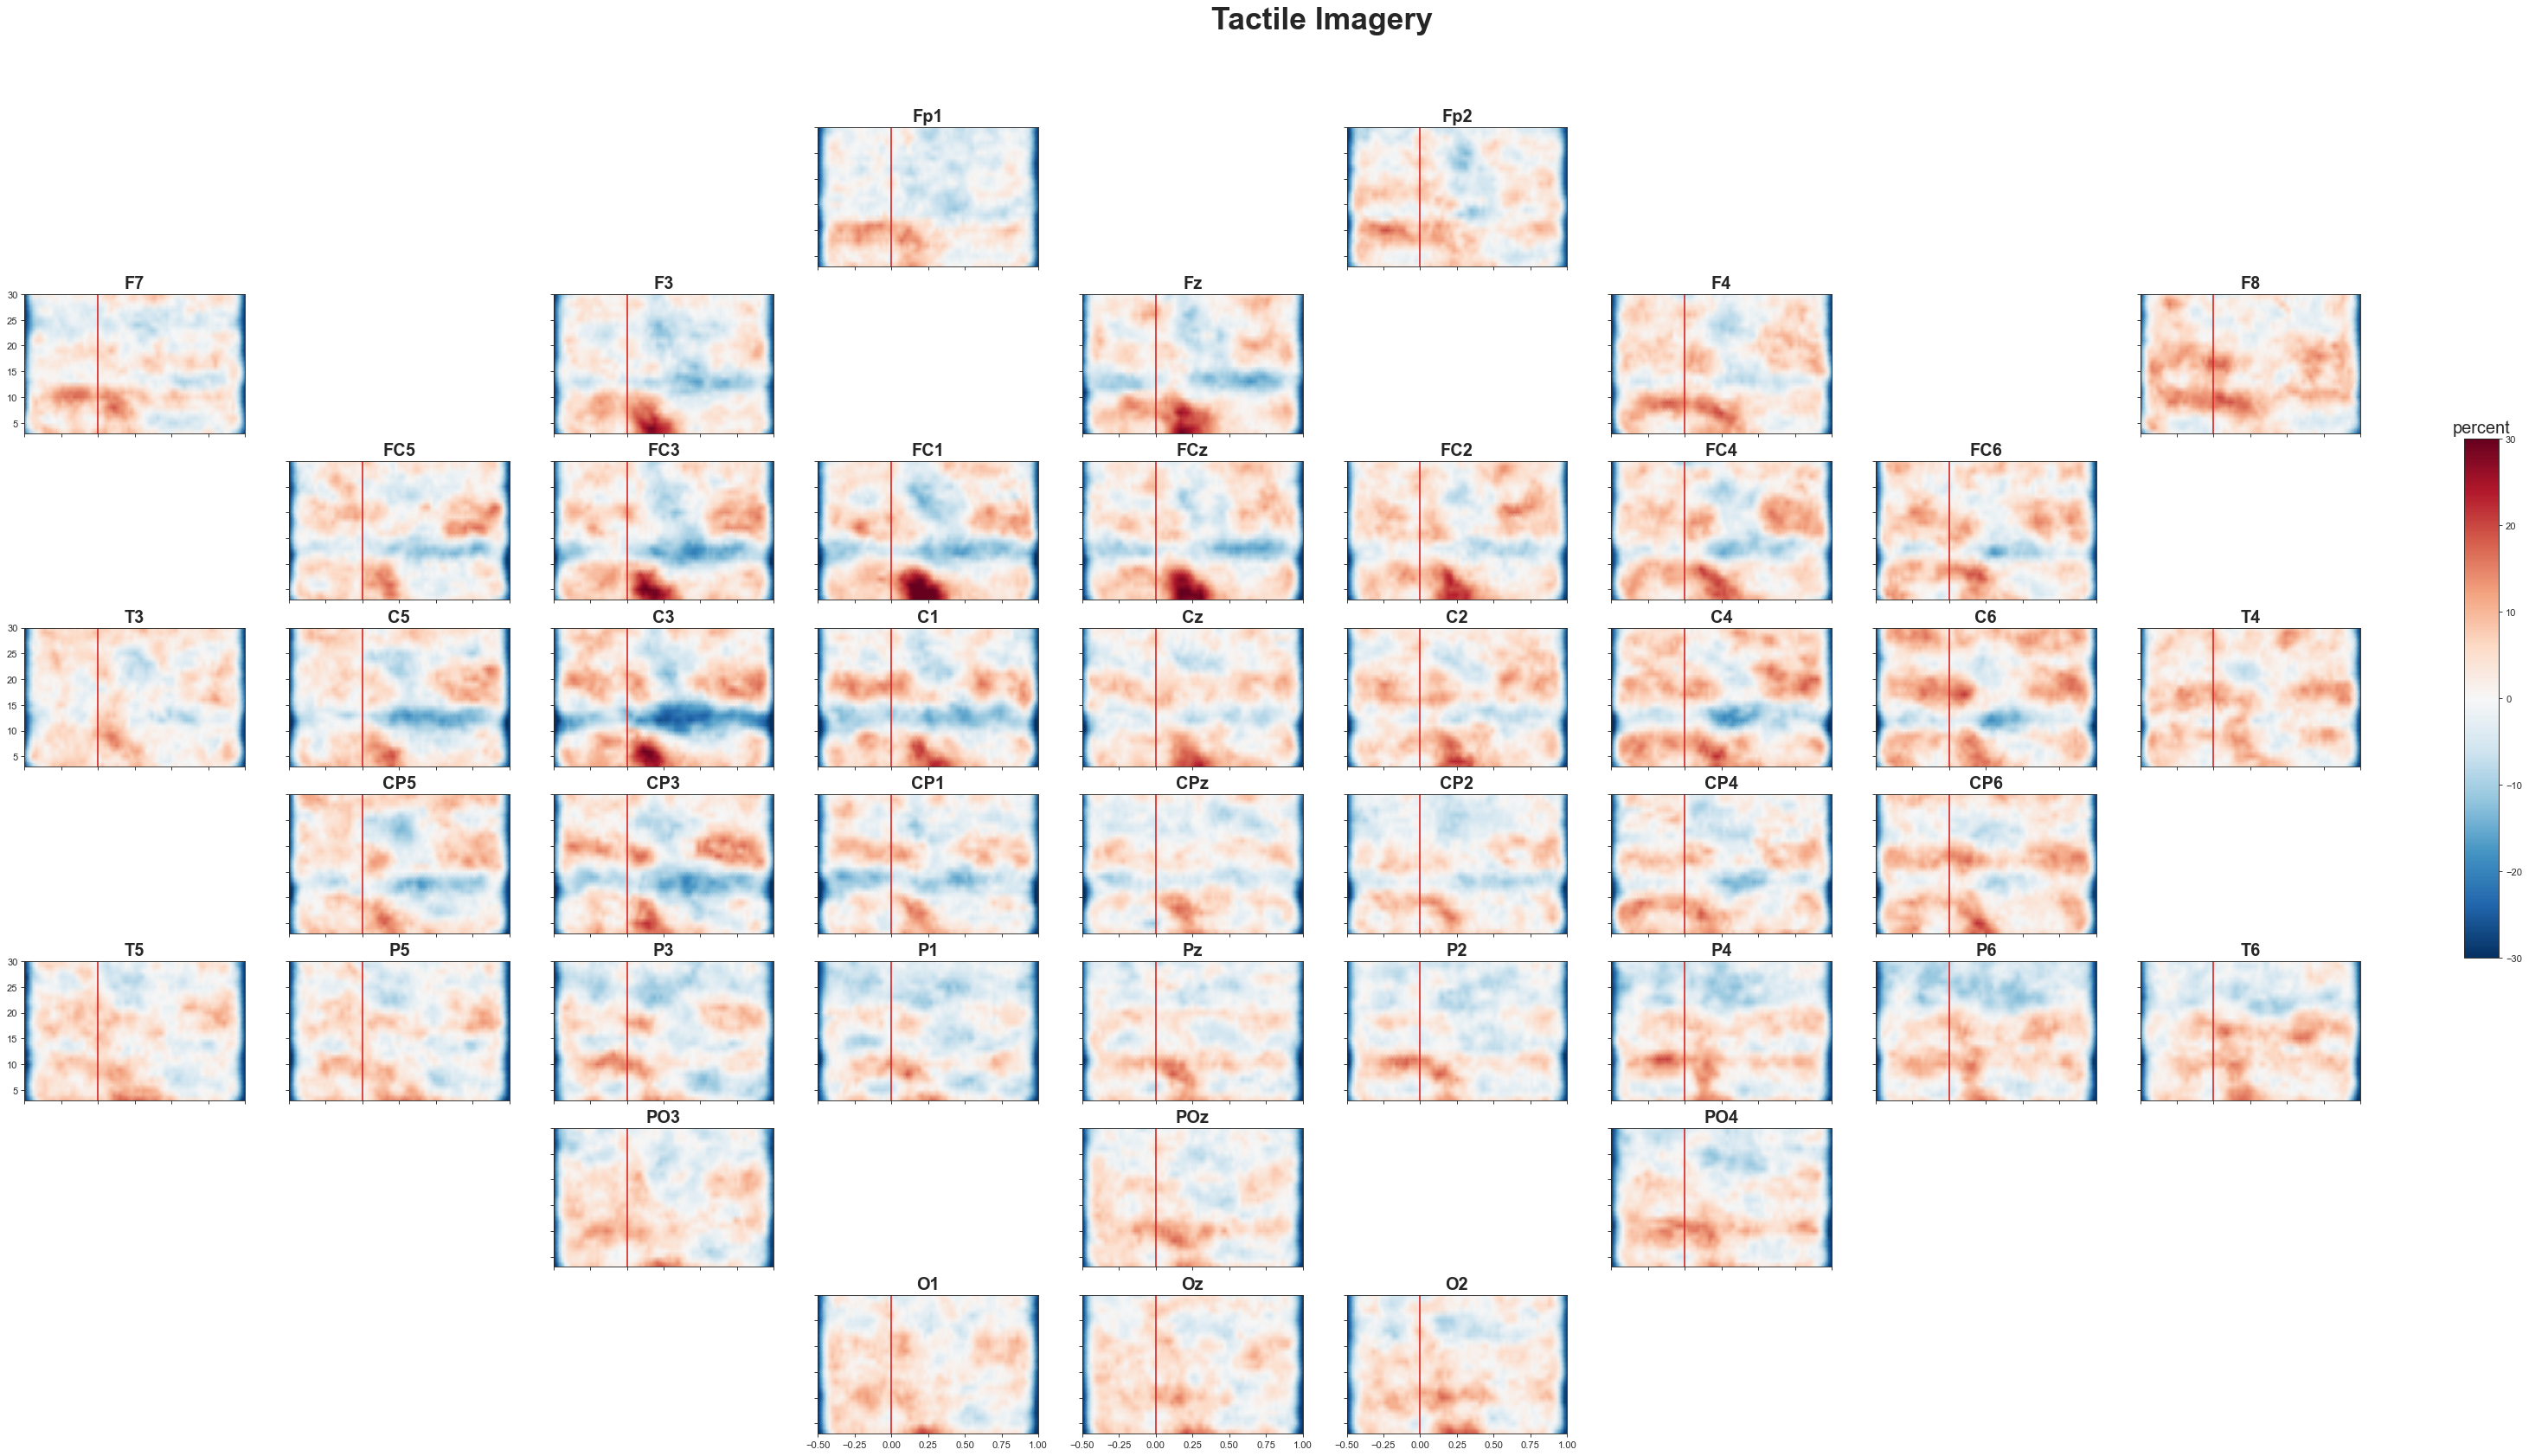

In [43]:
labels = ['Rest', 'Tactile Imagery']

vmin, vmax = -30, 30
freqs = np.arange(3, 31)
times = np.round(np.linspace(-0.5, 1, 75), 2)

for j, tfr in enumerate([rest_erp_w[not_cond], im_erp_w[not_cond]]):
    
    figure, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50, 25), sharex=True, sharey=True, dpi=80)

    for e in range(len(electrodes)):
        if electrodes[e] in ['TP9', 'TP10']:
            continue
        cp = axes[rows_seq[e]][cols_seq[e]].pcolormesh(times, freqs, np.median(tfr[:, e], axis=0)*100, vmin=vmin, vmax=vmax, cmap='RdBu_r', shading='gouraud')
        axes[rows_seq[e]][cols_seq[e]].set_title(electrodes[e], fontsize=18, fontweight='bold')
        axes[rows_seq[e]][cols_seq[e]].axvline(0, color='tab:red')
#             axes[rows_seq[e]][cols_seq[e]].axhline(mu_f, color='tab:red')

    pairs = [str(rows_seq[i])+str(cols_seq[i]) for i in range(len(electrodes))]

    for row in range(nrows):
        for col in range(ncols):
            if str(row) + str(col) not in pairs:
                axes[row][col].set_axis_off()

    figure.subplots_adjust(right=0.8)
    cbar_ax = figure.add_axes([0.83, 0.4, 0.01, 0.3])
    cbar = figure.colorbar(cp, cax=cbar_ax)
    cbar.ax.set_title('percent', fontsize=18)

    suptitle = plt.suptitle(labels[j], fontsize=32, y=0.95, fontweight='bold')
    plt.savefig('figs/'+labels[j]+'_median_short_wavelets.jpg', bbox_extra_artists=[suptitle], bbox_inches='tight')
    plt.show()

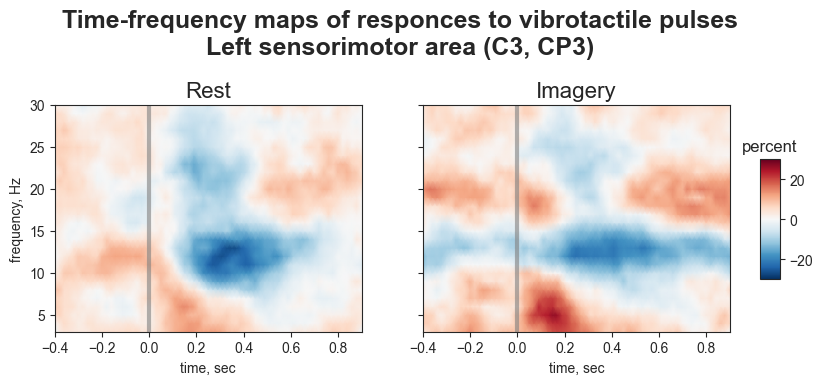

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3), dpi=100, sharex=True, sharey=True)
labels = ['Rest', 'Imagery']

left_sm = [electrodes.index(i) for i in ['C3', 'CP3']]

f1 = 16
f2 = 20

vmin,vmax = -30, 30

freqs = np.arange(3, 31)
times = np.round(np.linspace(-0.5, 1, 75), 2)

for i, tfr in enumerate([rest_erp_w[not_cond], im_erp_w[not_cond]]):
    
    cp = axes[i].pcolormesh(times, freqs, np.median(tfr[:, left_sm, :, :], axis=(0, 1))*100, vmin=vmin, vmax=vmax, cmap='RdBu_r', shading='gouraud')
    axes[i].axvline(0, color='tab:grey', alpha=0.6, linewidth=3)
    axes[i].set_title(labels[i], fontsize=f1)

axes[0].set_ylabel('frequency, Hz')  
axes[0].set_xlabel('time, sec')
axes[1].set_xlabel('time, sec')
    
suptitle = plt.suptitle('Time-frequency maps of responces to vibrotactile pulses\nLeft sensorimotor area (C3, CP3)', fontsize=18, fontweight='bold', x=0.47, y=1.2)
    
axes[i].set_xlim(-0.4, 0.9)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.3, 0.02, 0.4])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.ax.set_title('percent')

plt.savefig('figs/wavelets_powers_pulses.jpg', bbox_extra_artists=[suptitle])

In [45]:
t1_theta_i, t2_theta_i = 30, 40
theta_f1 = np.where(freqs == 3)[0][0]
theta_f2 = np.where(freqs == 8)[0][0]

t1_mu_i, t2_mu_i = 30, 55
t1_beta_i, t2_beta_i = 30, 40

pulse_theta = np.zeros((2, n_part, 47))
pulse_ind_mu = np.zeros((2, n_part, 47))
pulse_ind_beta = np.zeros((2, n_part, 47))

pulse_theta[0] = np.median(rest_erp_w[:, :, theta_f1:theta_f2, t1_theta_i:t2_theta_i], axis=(-1, -2))
pulse_theta[1] = np.median(im_erp_w[:, :, theta_f1:theta_f2, t1_theta_i:t2_theta_i], axis=(-1, -2))

for i in range(n_part):
    
    fi = np.where(freqs == mu_ind_values[i])[0][0]
    mu_mean = np.median(rest_erp_w[i, :, (fi-1):(fi+2), t1_mu_i:t2_mu_i], axis=(-1, -2))
    pulse_ind_mu[0, i] = mu_mean
    mu_mean = np.median(im_erp_w[i, :, (fi-1):(fi+2), t1_mu_i:t2_mu_i], axis=(-1, -2))
    pulse_ind_mu[1, i] = mu_mean
    
    fi = np.where(freqs == beta_ind_values[i])[0][0]
    beta_mean = np.median(rest_erp_w[i, :, (fi-1):(fi+2), t1_beta_i:t2_beta_i], axis=(-1, -2))
    pulse_ind_beta[0, i] = beta_mean
    beta_mean = np.median(im_erp_w[i, :, (fi-1):(fi+2), t1_beta_i:t2_beta_i], axis=(-1, -2))
    pulse_ind_beta[1, i] = beta_mean

In [46]:
theta_roi = [electrodes.index(i) for i in ['Fz', 'F3', 'FCz', 'FC1', 'FC3']]
sm_left = [electrodes.index(i) for i in ['C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1']]

In [47]:
pulse_theta = pulse_theta[:, not_cond]
pulse_ind_mu = pulse_ind_mu[:, not_cond]
pulse_ind_beta = pulse_ind_beta[:, not_cond]

<ipython-input-48-f39677083aa9>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


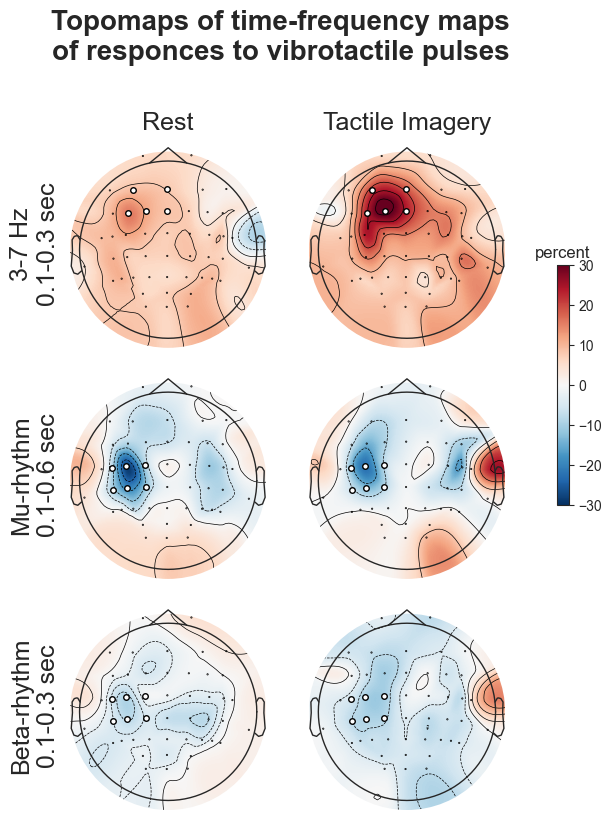

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(6, 8), dpi=100)

vlim = (-30, 30)
f1, f2 = 18, 20

for i in range(2):
    average = np.median(pulse_theta[i], axis=(0))
    mne.viz.plot_topomap(average*100, info, axes=axes[0][i if i==0 else 1], vlim=vlim, cmap='RdBu_r',
                         mask=np.array([True if e in theta_roi else False for e in range(len(electrodes))]),
                         show=False)
    
for i in range(2):
    average = np.median(pulse_ind_mu[i], axis=(0))
    im, cm = mne.viz.plot_topomap(average*100, info, axes=axes[1][i if i==0 else 1], vlim=vlim, cmap='RdBu_r',
                         mask=np.array([True if e in sm_left else False for e in range(len(electrodes))]),
                         show=False)
    
for i in range(2):
    average = np.median(pulse_ind_beta[i], axis=(0))
    mne.viz.plot_topomap(average*100, info, axes=axes[2][i if i==0 else 1], vlim=vlim, cmap='RdBu_r',
                         mask=np.array([True if e in sm_left else False for e in range(len(electrodes))]),
                         show=False)
    
axes[0][0].set_title('Rest', fontsize=f1)
axes[0][1].set_title('Tactile Imagery', fontsize=f1)

axes[0][0].set_ylabel(f'3-7 Hz\n{times[t1_theta_i].round(1)}-{times[t2_theta_i].round(1)} sec', fontsize=f1)
axes[1][0].set_ylabel(f'Mu-rhythm\n{times[t1_mu_i].round(1)}-{times[t2_mu_i].round(1)} sec', fontsize=f1)
axes[2][0].set_ylabel(f'Beta-rhythm\n{times[t1_beta_i].round(1)}-{times[t2_beta_i].round(1)} sec', fontsize=f1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.96, 0.4, 0.02, 0.3])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title('percent')

suptitle = plt.suptitle('Topomaps of time-frequency maps\nof responces to vibrotactile pulses', fontsize=f2, fontweight='bold', y=1.02)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1, right=0.9)

plt.savefig('figs/topomaps_powers_pulses.jpg', bbox_extra_artists=[suptitle])

In [49]:
avg = np.median(pulse_theta[..., theta_roi], axis=-1)
df_theta = pd.DataFrame({
    'theta_power':list(avg.reshape(-1)),
    'condition':['rest']*pulse_theta.shape[1]+['imagery']*pulse_theta.shape[1],
    'id':list(range(pulse_theta.shape[1]))*2
})

avg = np.median(pulse_ind_mu[..., sm_left], axis=-1)
df_mu = pd.DataFrame({
    'mu_power':list(avg.reshape(-1)),
    'condition':['rest']*pulse_ind_mu.shape[1]+['imagery']*pulse_ind_mu.shape[1],
    'id':list(range(pulse_ind_mu.shape[1]))*2
})

avg = np.median(pulse_ind_beta[..., sm_left], axis=-1)
df_beta = pd.DataFrame({
    'beta_power':list(avg.reshape(-1)),
    'condition':['rest']*pulse_ind_beta.shape[1]+['imagery']*pulse_ind_beta.shape[1],
    'id':list(range(pulse_ind_beta.shape[1]))*2
})

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
rest v.s. imagery: Wilcoxon test (paired samples), P_val=1.289e-03 stat=6.700e+01
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
rest v.s. imagery: Wilcoxon test (paired samples), P_val=5.519e-01 stat=1.760e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
rest v.s. imagery: Wilcoxon test (paired samples), P_val=9.553e-01 stat=2.000e+02


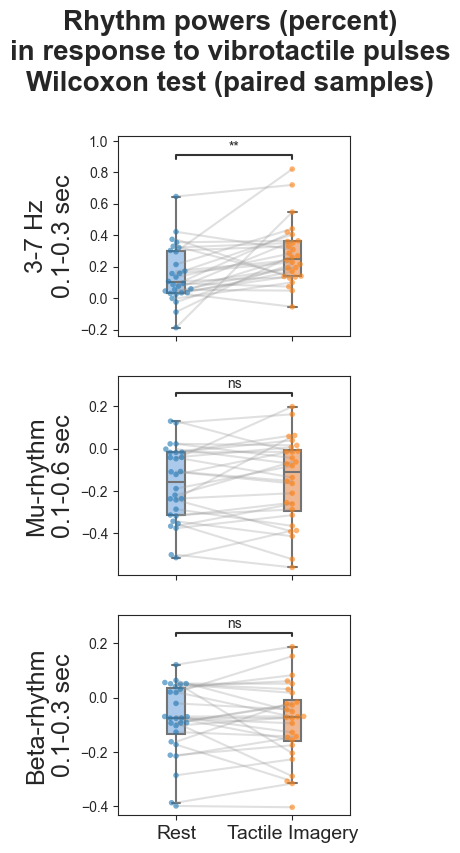

In [50]:
box_pairs = [
    ('rest', 'imagery')
]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(3, 9), dpi=100, sharex=True)

sns.boxplot(data=df_theta, x='condition', y='theta_power', showfliers=False, palette='pastel', ax=axes[0], width=0.15)
g = sns.swarmplot(data=df_theta, x='condition', y='theta_power', alpha=0.6, ax=axes[0], size=4)
sns.lineplot(data=df_theta, y='theta_power', x='condition', hue='id', sort=False, palette=sns.color_palette(["#999999"]*len(np.unique(df_theta.id))),
             estimator=None, legend=False, ax=axes[0], alpha=0.3)

test_results = add_stat_annotation(g, data=df_theta, x='condition', y='theta_power',
                                   box_pairs=box_pairs, comparisons_correction=None,
                                   test='Wilcoxon', text_format='star',
                                   loc='inside', verbose=2)

sns.boxplot(data=df_mu, x='condition', y='mu_power', showfliers=False, palette='pastel', ax=axes[1], width=0.15)
g = sns.swarmplot(data=df_mu, x='condition', y='mu_power', alpha=0.6, ax=axes[1], size=4)
sns.lineplot(data=df_mu, y='mu_power', x='condition', hue='id', sort=False, palette=sns.color_palette(["#999999"]*len(np.unique(df_theta.id))),
             estimator=None, legend=False, ax=axes[1], alpha=0.3)

test_results = add_stat_annotation(g, data=df_mu, x='condition', y='mu_power',
                                   box_pairs=box_pairs, comparisons_correction=None,
                                   test='Wilcoxon', text_format='star',
                                   loc='inside', verbose=2)

sns.boxplot(data=df_beta, x='condition', y='beta_power', showfliers=False, palette='pastel', ax=axes[2], width=0.15)
g = sns.swarmplot(data=df_beta, x='condition', y='beta_power', alpha=0.6, ax=axes[2], size=4)
sns.lineplot(data=df_beta, y='beta_power', x='condition', hue='id', sort=False, palette=sns.color_palette(["#999999"]*len(np.unique(df_theta.id))),
             estimator=None, legend=False, ax=axes[2], alpha=0.3)

test_results = add_stat_annotation(g, data=df_beta, x='condition', y='beta_power',
                                   box_pairs=box_pairs, comparisons_correction=None,
                                   test='Wilcoxon', text_format='star',
                                   loc='inside', verbose=2)

axes[0].set_ylabel(f'3-7 Hz\n{times[t1_theta_i].round(1)}-{times[t2_theta_i].round(1)} sec', fontsize=f1)
axes[1].set_ylabel(f'Mu-rhythm\n{times[t1_mu_i].round(1)}-{times[t2_mu_i].round(1)} sec', fontsize=f1)
axes[2].set_ylabel(f'Beta-rhythm\n{times[t1_beta_i].round(1)}-{times[t2_beta_i].round(1)} sec', fontsize=f1)

# plt.xticks(['rest', 'im_im'], ['Rest', 'Imagery'])
axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')

axes[-1].set_xticklabels(['Rest', 'Tactile Imagery'], rotation=0, size=14)

# leg = axes[0].legend(loc=2)
# leg.set_title('Fz, F3\nFCz, FC1, FC3',prop={'size':8})

# leg = axes[1].legend(loc=2)
# leg.set_title('C5, C3, C1\nCP5, CP3, CP1',prop={'size':8})

# leg = axes[2].legend(loc=2)
# leg.set_title('C5, C3, C1\nCP5, CP3, CP1',prop={'size':8})

suptitle = plt.suptitle('Rhythm powers (percent)\nin response to vibrotactile pulses\nWilcoxon test (paired samples)', fontsize=f2, y=1.02, fontweight='bold')
plt.savefig('figs/boxplots_powers_pulses.jpg', bbox_extra_artists=[suptitle], bbox_inches='tight')